# Exercise 8.6 

# Importing all the necessary libraries

In [1]:
import matplotlib.pyplot as plt
from multiprocessing import Process
import seaborn as sns
import numpy as np
from cvxopt import matrix, solvers
import random
import warnings
warnings.filterwarnings("ignore")

# Generate the training samples

In [2]:
def generateRandomPoints(N=20):
    x = np.zeros((N, 2), dtype=np.float)
    x[:, 0] = np.random.rand(N)
    x[:, 1] = 2*np.random.rand(N)- 1 
    y = np.sign(x[:, 1])
    return x, y

# Calculate the error

In [3]:
def calculateErrorout(w_hat, n_samples=5000):
    x, y = generateRandomPoints(n_samples)
    N = x.shape[0]
    concatenated_x = np.concatenate((np.ones((N, 1)), x), axis=1)
    prediction = np.matmul(concatenated_x, w_hat).reshape(-1)
    prediction = np.sign(prediction) - (prediction == 0)
    error_out = 1 - (np.count_nonzero(prediction == y) / N)
    return error_out

# Declaring SVM

In [4]:
class SVM():
    def __init__(self):
        self.sp_v_threshold = 0.0000001
    def fit_data(self, x, y):
        support_vector_indices = []
        N = len(x)
        DIMENSION = len(x[0])
        P = matrix(np.identity(DIMENSION + 1))
        P[0, 0] = 0
        G = matrix(np.zeros((N, DIMENSION + 1)))
        for i in range(N):
            G[i, 0] = -y[i]
            G[i, 1:] = -x[i, :] * y[i]
        q = matrix(np.zeros((DIMENSION + 1,)))
        h = -matrix(np.ones((N,)))
        solv = solvers.qp(P, q, G, h)
        weights= np.zeros(DIMENSION,)
        b = solv["x"][0]
        for i in range(1, DIMENSION + 1):
            weights[i - 1] = solv["x"][i]
        for k in range(N):
            val = y[k] * (np.dot(weights, x[k]) + b)
            if val < (1 + self.sp_v_threshold):
                support_vector_indices.append(k)
        self.intercept = np.array([b])
        self.coefficient = weights.reshape(-1, 1)
def returnConcatenatedSVM(X, y):
    svm = SVM()
    svm.fit_data(X, y)
    concatenated_svm = np.concatenate((svm.intercept.reshape(1,1), svm.coefficient.reshape(-1, 1)),0)
    return concatenated_svm

# Declaring PLA

In [5]:
def PLA(x, y):
    N = x.shape[0]
    concatenated_x = np.concatenate((np.ones((N, 1)), x), axis=1)
    w = np.zeros((concatenated_x.shape[1], 1))
    maximumupdates=1500
    for updates in range(maximumupdates):
        prediction = np.matmul(concatenated_x, w)
        prediction = np.sign(prediction) - (prediction == 0)
        prediction = prediction.reshape(-1)
        for i, j in enumerate(prediction != y):
            if j == 1:
                break
            if i == x.shape[0] - 1:
                return w
        w += y[i] * concatenated_x[i, :].reshape(-1, 1)
    return w

# Comparing the results

In [6]:
def compareSVMandPLA():
    x, y = generateRandomPoints()
    SVM_error_out_of_sample = calculateErrorout(returnConcatenatedSVM(x, y))
    PLA_error_out_of_sample = []
    iterations = 5000
    for iters in range(iterations):
        i = np.random.permutation(x.shape[0])
        x = x[i]
        y = y[i]
        PLA_error_out_of_sample.append(calculateErrorout(PLA(x, y)))
    PLA_error_out_of_sample = np.array(PLA_error_out_of_sample)
    return SVM_error_out_of_sample, PLA_error_out_of_sample

# Generating samples and running everything

In [7]:
x, y = generateRandomPoints()
w_hat_svm = returnConcatenatedSVM(x, y)
w_hat_pla = PLA(x, y)

     pcost       dcost       gap    pres   dres
 0:  7.9613e-01  1.0459e+01  5e+01  2e+00  2e+01
 1:  5.0087e+00 -2.1621e-01  2e+01  7e-01  6e+00
 2:  8.0068e+00  5.4934e+00  8e+00  2e-01  2e+00
 3:  1.1625e+01  9.3348e+00  3e+00  5e-02  4e-01
 4:  1.2221e+01  1.2126e+01  1e-01  7e-04  6e-03
 5:  1.2193e+01  1.2192e+01  1e-03  7e-06  6e-05
 6:  1.2192e+01  1.2192e+01  1e-05  7e-08  6e-07
 7:  1.2192e+01  1.2192e+01  1e-07  7e-10  6e-09
Optimal solution found.


# Calling the comparison function

In [8]:
E_out_SVM, E_outs_PLA = compareSVMandPLA()

     pcost       dcost       gap    pres   dres
 0:  1.0999e+00  1.5064e+01  5e+01  2e+00  1e+01
 1:  5.6889e+00  1.2563e+01  2e+01  8e-01  4e+00
 2:  1.7337e+01  5.1226e+01  2e+01  6e-01  3e+00
 3:  4.9645e+01  6.1561e+01  1e+01  2e-01  1e+00
 4:  6.5607e+01  6.5910e+01  5e-01  6e-03  3e-02
 5:  6.6064e+01  6.6067e+01  5e-03  6e-05  3e-04
 6:  6.6068e+01  6.6069e+01  5e-05  6e-07  3e-06
 7:  6.6069e+01  6.6069e+01  5e-07  6e-09  3e-08
Optimal solution found.


# Plotting all the data

Text(0.049319333333333375, 126.94500000000001, '$E_{out}SVM$')

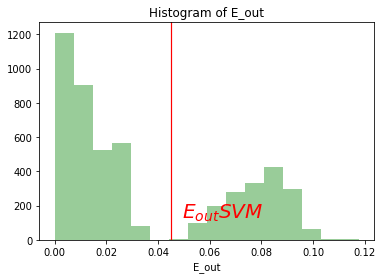

In [9]:
axes = sns.distplot(E_outs_PLA, kde=False, color= 'g')
plt.axvline(E_out_SVM, color="red", lw=1.2)
plt.title('Histogram of E_out')
plt.xlabel('E_out')
plt.text(E_out_SVM + (axes.axis()[1] - axes.axis()[0]) / 30, 0.1 * axes.axis()[3], r'$E_{out}SVM$',fontsize=20, color = 'r')